# Classical time series analysis

This notebook aims at predicting future stock price using different classical approaches (detailed belows). 

In all these approach, the model learns to predict future prices based purely on historical prices. For each method, data from **2015** is used as historical data. Data from the last 30 days are used as validation, the prediction for the future is made.

## Algorithms used:

### Tripple exponential smoothing (aka Holt-winters)
**Intuition**: 
Decomposes price changes into 3 components: levels (think moving average), trends and seasonality

**Results**:
The validation is quite good. The model can predict the surprise price flips in the last month. Yet, the result for future prediction is quite doubtful.

### SARIMA:
**Intuition**:
The name of the model speaks for itself. Let's break it donw word by word:
* AR: autoregression. The model makes prediction by fitting regression model onto its own historical data.
* MA: moving average.
* S: seasonality. Takes care of periodic pattern
* I: order of integration. Simply speaking, the differrentiation order needed to make the model stationary

**Results**:
* In validation set, the model follow the recent trend and thus incorrect. This results, however, actually makes more sense since the recent price flip is quite abrupt and unpredictable. The future prediction makes more sense as cimpared to exponential smoothing, but too flat I think.

**Credits**: Most of things I learnt, and even some codes, to make this notebook are taken from [here](https://mlcourse.ai/articles/topic9-part1-time-series/)

## Import libraries and data

In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
from scipy import stats
import datetime
import seaborn as sns                   

from dateutil.relativedelta import relativedelta
from scipy.optimize import minimize     

import statsmodels.formula.api as smf       
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product  

# Library for plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from matplotlib import rcParams
params = {
    'font.size': 12,
    'axes.labelsize': 15,
    'axes.titlesize': 18

}
rcParams.update(params)
rcParams['figure.figsize'] = 10, 5
rcParams['figure.dpi'] = 100

from mplfinance.original_flavor import candlestick2_ohlc
import mplfinance as mpf

/Users/dangminh.nguyen/opt/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
# Stock price
asset = "^GSPC"
df_orig = wb.DataReader('^GSPC', data_source='yahoo', start='1995-1-1')
df_orig.dtypes

High         float64
Low          float64
Open         float64
Close        float64
Volume         int64
Adj Close    float64
dtype: object

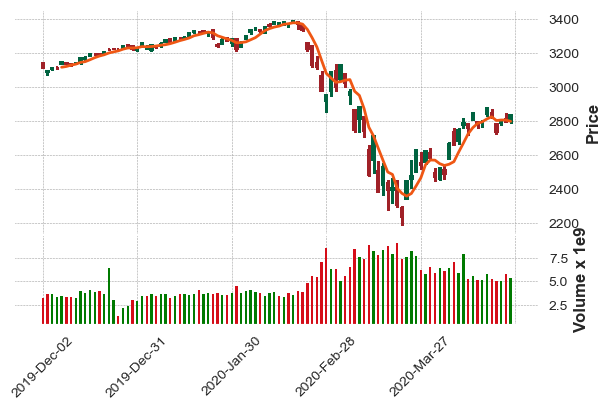

In [3]:
df_plt = df_orig[-100:]
kwargs = dict(type='candle',mav=(5),volume=True,figratio=(10,6),figscale=0.75)
mpf.plot(df_plt,**kwargs,style='charles')

In [4]:
# Importing everything from above

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Exponential smoothing
### Build and validate

In [54]:
df = df_orig.copy()

In [55]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

In [56]:
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [59]:
pred_idx = -30
data = df['Adj Close'][-1000:pred_idx] 
slen = 50 # 1 quarter seasonality

x = [0, 0, 0] 

opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_absolute_percentage_error, slen), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

model = HoltWinters(data, slen = slen, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 30, scaling_factor = 3)
model.triple_exponential_smoothing()

0.9999999999982833 0.00017682474524238767 0.0


In [60]:
def plot_time(y_train, y_pred, start_date=None, y_val=None):
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)
    x_train = np.arange(-len(y_train),0,1)
    x_pred = np.arange(1,len(y_pred)+1,1)
    plt.plot(x_train, y_train, color='black', linewidth=1.5, label='Historical price')
    plt.plot(x_pred, y_pred, color='red',label='Prediction',alpha=0.8)
    try:
        x_val = np.arange(1,len(y_val)+1,1)
        plt.plot(x_val, y_val, color='blue',label='Val',alpha=0.6)
    except:
        pass
    plt.xlabel('Days')
    plt.ylabel('Price')
    fig.canvas.draw()
    
    # Label start date
    labels = [item.get_text() for item in ax.get_xticklabels()]
    
    if start_date != None:
        for i in range(len(labels)):
            if labels[i] == '0':
                labels[i] = start_date
    ax.set_xticklabels(labels)
    plt.legend(loc='best')

In [62]:
y_train = df[-250:pred_idx]['Adj Close']
y_pred = model.result[len(data):]
y_val = df[pred_idx:]['Adj Close']
start_date = df.index[pred_idx]

Text(0.5, 1, 'Price prediction using exponential smoothing')

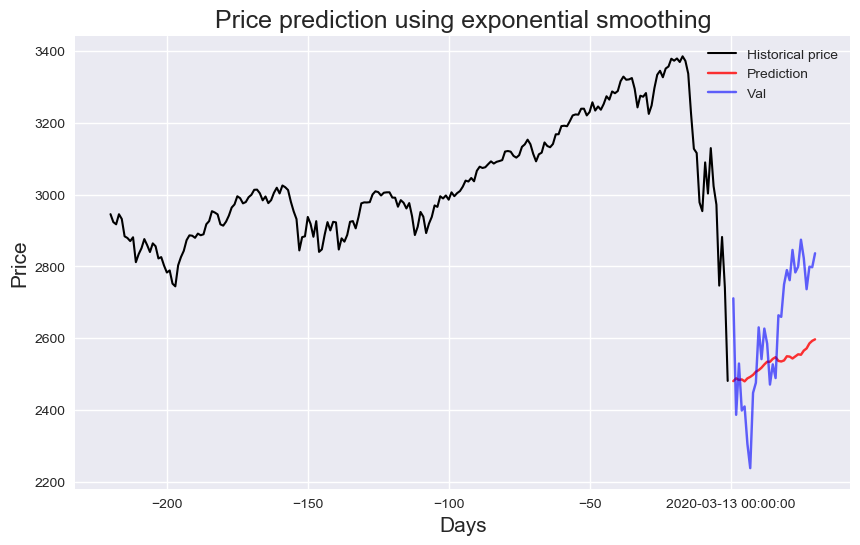

In [64]:
plot_time(y_train, y_pred, start_date, y_val)
plt.title('Price prediction using exponential smoothing')

### Future prediction

In [65]:
pred_idx = -30
data = df['Adj Close'][-1000:] 
slen = 50 # 1 quarter seasonality

x = [0, 0, 0] 

opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_absolute_percentage_error, slen), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

model = HoltWinters(data, slen = slen, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 30, scaling_factor = 3)
model.triple_exponential_smoothing()

0.035143096367036 0.015215428687266996 0.06353533957874419


In [66]:
y_train = df[-200:]['Adj Close']
y_pred = model.result[len(data):]
start_date = df.index[-1]

Text(0.5, 1, 'Future price prediction')

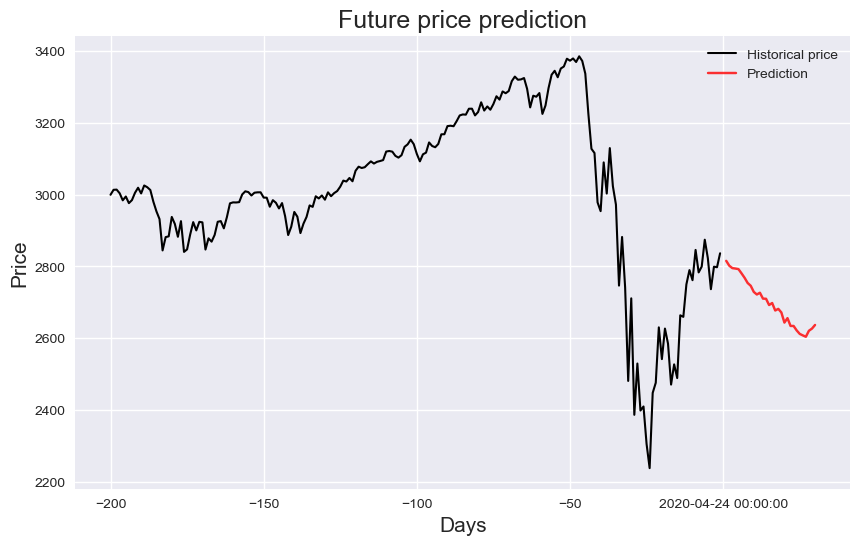

In [67]:
plot_time(y_train, y_pred, start_date)
plt.title('Future price prediction')

## SARIMA
### Stationary checking

In [68]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

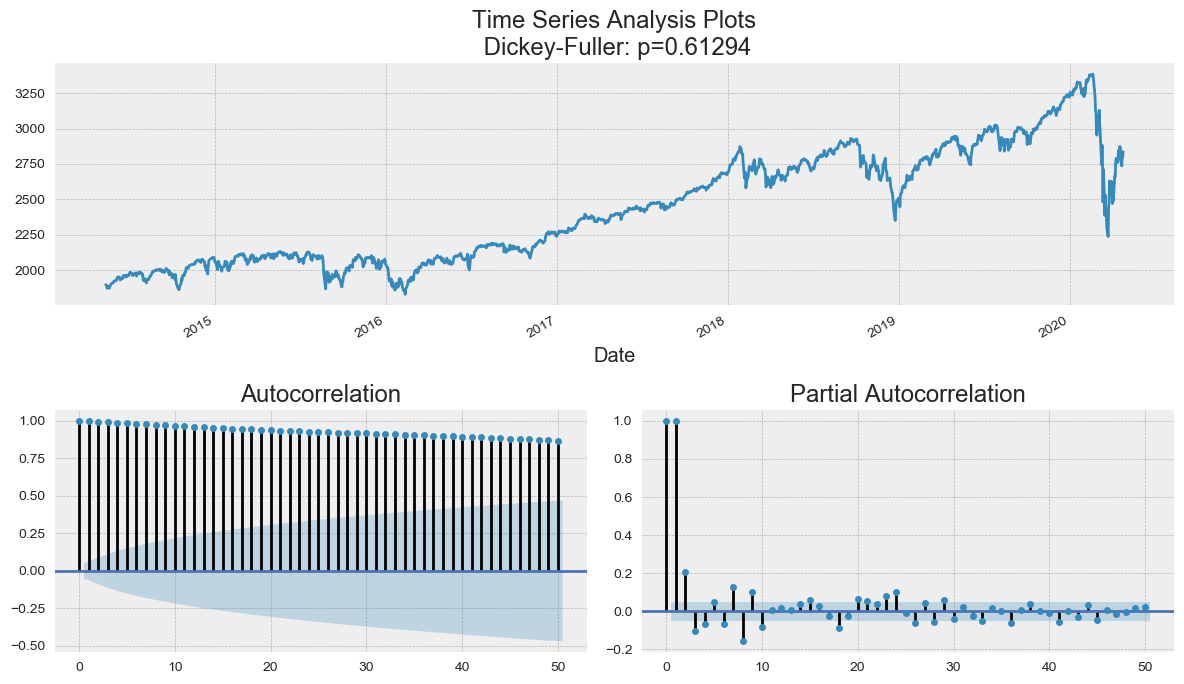

In [79]:
tsplot(df['Adj Close'][-1500:], lags=50)

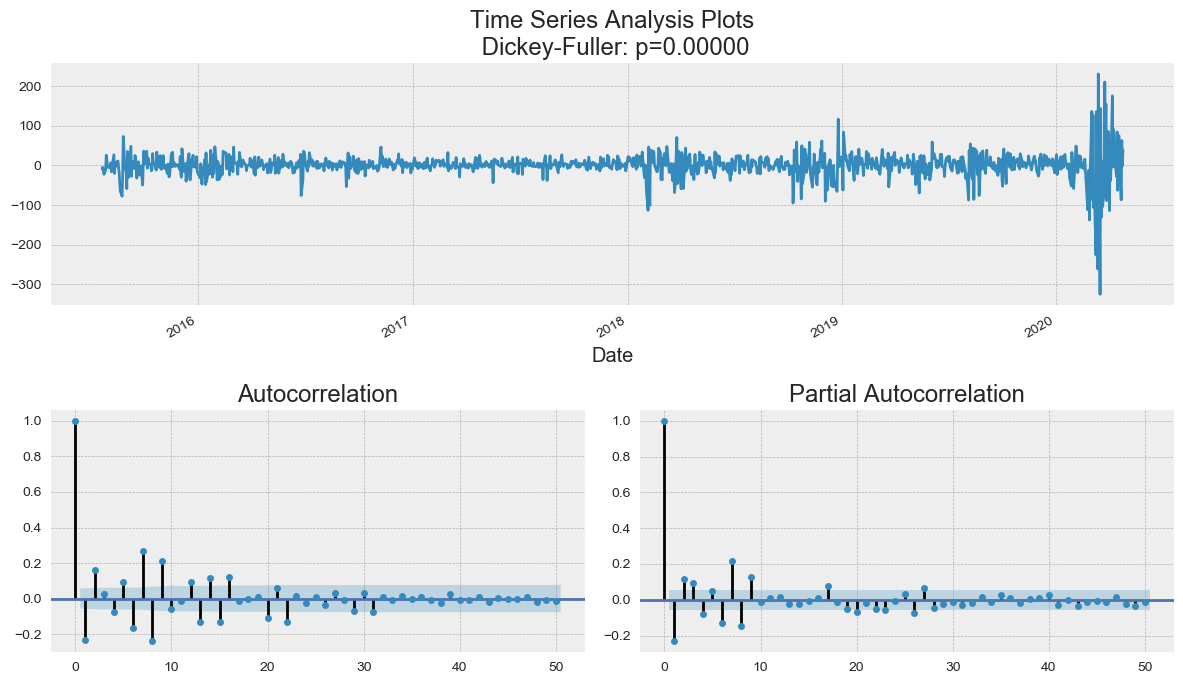

In [86]:
price_diff = df['Adj Close']- df['Adj Close'].shift(1)
tsplot(price_diff[-1200:], lags=50)

### Build model and validate

In [87]:
# Setup SARIMA parameter
p = 9 # lag order
d = 1 # integration order
q = 9 # moving average order

P = 1 # seasonal components for PACF plot
Q = 1 # seasonal components for ACF plot
D = 1 # apply seasonal difference
s = 22 # seasonal is 1 month

In [88]:
data = df['Adj Close'][-1500:pred_idx]

In [89]:
model=sm.tsa.statespace.SARIMAX(data, order=(p, d, q), 
                                    seasonal_order=(P, D, Q, s)).fit(disp=-1)

/Users/dangminh.nguyen/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/dangminh.nguyen/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/dangminh.nguyen/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/dangminh.nguyen/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible sta

In [90]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            Adj Close   No. Observations:                 1470
Model:             SARIMAX(9, 1, 9)x(1, 1, [1], 22)   Log Likelihood               -6682.693
Date:                              Sun, 26 Apr 2020   AIC                          13407.385
Time:                                      15:14:39   BIC                          13518.208
Sample:                                           0   HQIC                         13448.745
                                             - 1470                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9857      0.465      2.120      0.034       0.075       1.897
ar.L2         -0.3111      0.390     -0.797      0.425      -1.076       0.454
ar.L3          0.0032      0.257      0.013      0.990      -0.501       0.507
ar.L4          0.0297      0.214      0.139      0.889      -0.389       0.449
ar.L5         -0.2636      0.180     -1.468      0.142      -0.616       0.088
ar.L6          0.0846      0.265      0.319      0.750      -0.436       0.605
ar.L7          0.6044      0.224      2.702      0.007       0.166       1.043
ar.L8         -0.8741      0.395     -2.213      0.027      -1.648      -0.100
ar.L9          0.7084      0.352      2.011      0.044       0.018       1.399
ma.L1         -1.0227      0.463     -2.209      0.027      -1.930      -0.115
ma.L2          0.3680      0.395      0.931      0.352      -0.407       1.143
ma.L3         -0.0101      0.249     -0.040      0.968      -0.498       0.478
ma.L4         -0.0439      0.197     -0.224      0.823      -0.429       0.341
ma.L5          0.2774      0.179      1.550      0.121      -0.073       0.628
ma.L6         -0.1236      0.265     -0.467      0.640      -0.642       0.395
ma.L7         -0.5472      0.224     -2.447      0.014      -0.986      -0.109
ma.L8          0.8491      0.378      2.246      0.025       0.108       1.590
ma.L9         -0.6937      0.341     -2.036      0.042      -1.362      -0.026
ar.S.L22      -0.0112      0.033     -0.336      0.737      -0.076       0.054
ma.S.L22      -0.9986      0.272     -3.672      0.000      -1.532      -0.466
sigma2       575.7757    150.870      3.816      0.000     280.075     871.476
===================================================================================
Ljung-Box (Q):                       49.17   Jarque-Bera (JB):             19299.73
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               3.17   Skew:                            -1.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        20.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

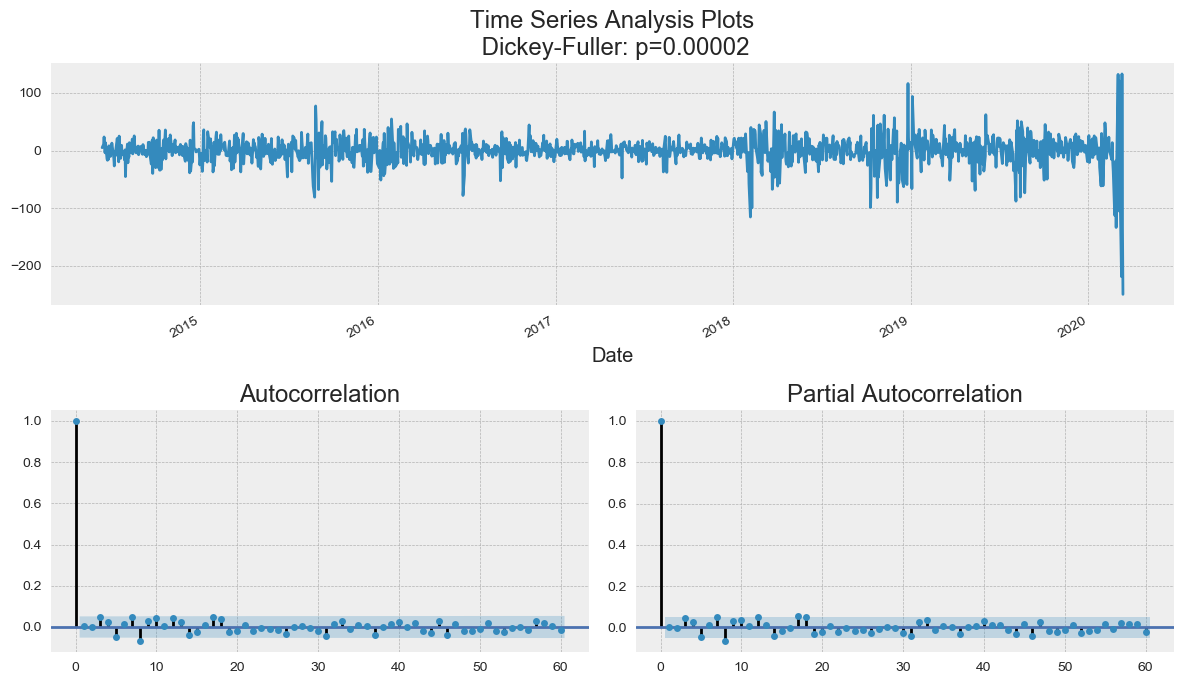

In [92]:
tsplot(model.resid[22+1:], lags=60)

In [93]:
forecast = model.predict(start = len(data), end=len(data)+np.abs(pred_idx))

/Users/dangminh.nguyen/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [95]:
y_train = df[-250:pred_idx]['Adj Close']
y_pred = forecast.values
y_val = df[pred_idx:]['Adj Close']
start_date = df.index[pred_idx]

Text(0.5, 1, 'Price prediction using SARIMA')

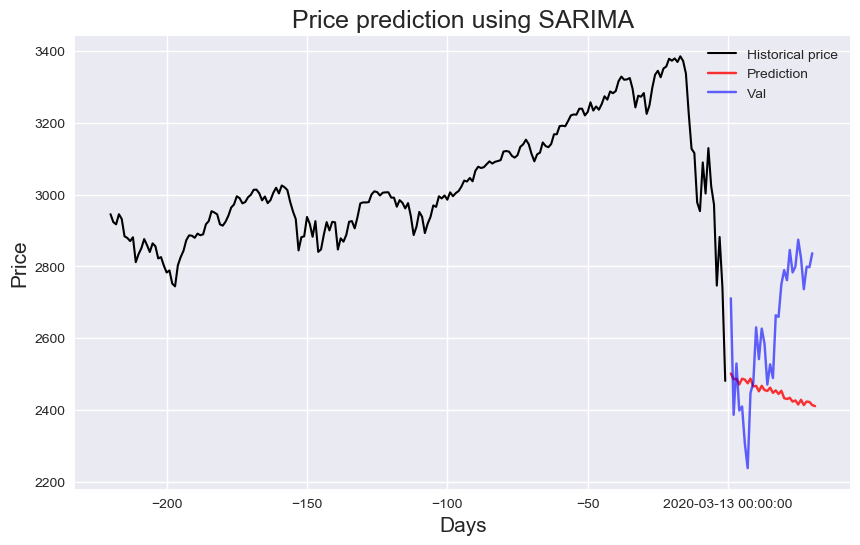

In [96]:
plot_time(y_train, y_pred, start_date, y_val)
plt.title('Price prediction using SARIMA')

### Future prediction

In [97]:
data = df['Adj Close'][-1500:]
model=sm.tsa.statespace.SARIMAX(data, order=(p, d, q), 
                                    seasonal_order=(P, D, Q, s)).fit(disp=-1)
forecast = model.predict(start = len(data), end=len(data)+np.abs(pred_idx))

/Users/dangminh.nguyen/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/dangminh.nguyen/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/dangminh.nguyen/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/dangminh.nguyen/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible sta

In [98]:
y_train = df[-200:]['Adj Close']
y_pred = forecast.values
start_date = df.index[-1]

Text(0.5, 1, 'Future price prediction using SARIMA')

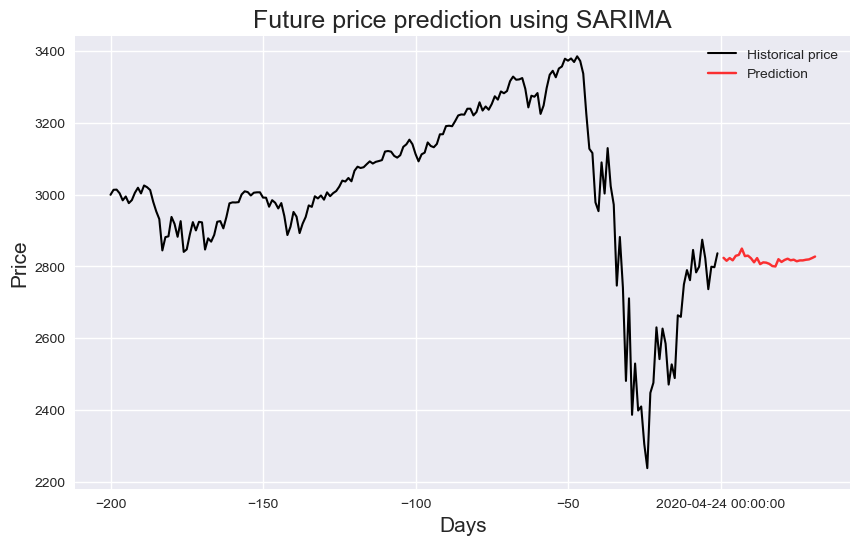

In [100]:
plot_time(y_train, y_pred, start_date)
plt.title('Future price prediction using SARIMA')